In [1]:

%%capture
!pip install hmmlearn
!pip install mne

In [2]:
import mne
import numpy as np
from sklearn.decomposition import PCA
from hmmlearn import hmm
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [90]:
from google.colab import files
uploaded = files.upload()

Saving matrix_concat_220208_0657.mat to matrix_concat_220208_0657 (1).mat


In [91]:
import scipy.io
mat = scipy.io.loadmat('matrix_concat_220208_0657.mat')

In [137]:
T = mat ["Value"]
#M = T.transpose()
L= T[30]
L = L[540:1260]
len(T)
n = mat ["Time"]
Time = n[0][540:1260]
time = Time.reshape(-1,1)


In [99]:
sos = signal.butter(5, [13, 30], 'bandpass', fs=120, output='sos')
filtered = signal.sosfilt(sos, L)

# Embedded Hidden Markov Model inference

0.8888888888888888

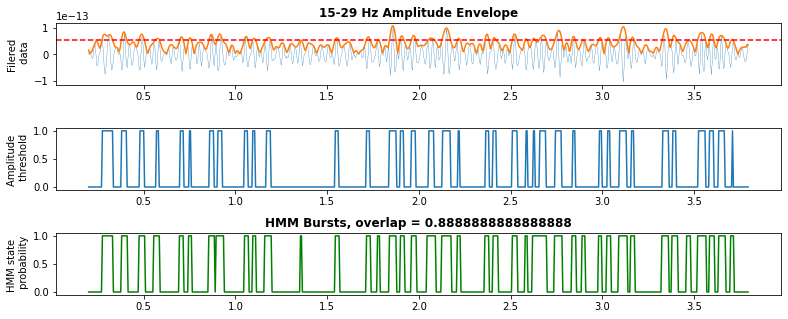

In [100]:
fig = plt.figure(figsize=(13, 5))
plt.subplots_adjust(hspace=0.7)
plt.subplot(311)
plt.title('15-29 Hz Amplitude Envelope', fontweight='bold')
plt.plot(time, filtered, label='signal', linewidth=.3)

analytic_signal = signal.hilbert(filtered)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(time, amplitude_envelope, label='envelope')
plt.ylabel('Filered \n data')
##plt.xlim(0, seconds)

# Here we generate an amplitude threshold using the Shin 2018 method
threshold = np.percentile(amplitude_envelope,75)
plt.axhline(y=threshold, linestyle='--', color='r')

plt.subplot(312)
plt.plot(time, amplitude_envelope>threshold)
#plt.fill_between(x=time, y1=amplitude_envelope>threshold, alpha=0.3)
plt.ylabel('Amplitude \n threshold')
#plt.xlim(0, seconds)

# HHM estimation
remodel = hmm.GMMHMM(n_components=2,covariance_type="full", n_iter=100)
remodel.fit(amplitude_envelope.reshape(-1, 1))
proba = remodel.predict_proba(amplitude_envelope.reshape(-1, 1))
q =proba[:, 0]
q[q > 0.66] = 1
q[q < 0.66] = 0

w=proba[:, 1]
w[w > 0.66] = 1
w[w < 0.66] = 0

z = amplitude_envelope>threshold
plt.subplot(313)

#plt.fill_between(x=time, y1=w, alpha=0.3, color='g')
plt.ylabel('HMM state \n probability')
if np.mean(w!=z) > np.mean(q!=z):
  b_state = q
else:
  b_state = w
plt.plot(time, b_state, 'g')
err = 1 - np.mean(b_state!=z)

plt.title('HMM Bursts, overlap = '+ str (err), fontweight='bold')
#print ('err = 1 - b_state')
plt.tight_layout
err

In [12]:
if np.mean(w!=z) > np.mean(q!=z):
  b_state = q
else:
  b_state = w

from itertools import groupby
j=0
grouped_L = [k for k,g in groupby(b_state)]
#h =[(k, (g+x for x-1 in g)) for k, g in groupby(grouped_L)]
grouped_L1= []
grouped_L3= []
grouped_L4= []
for k,g in groupby(b_state):
  j = j +sum(1 for i in g)
  grouped_L1.append (j)
#del grouped_L1[0]
grouped_L
o=0
bamp=0
if grouped_L[0]==0:
  for i in range(0,len(grouped_L1)-1,2):
  
    o = o+ sum(b_state[grouped_L1[i]:grouped_L1[i+1]])
    bamp = bamp+ sum(amplitude_envelope[grouped_L1[i]:grouped_L1[i+1]])

  #o = o+ sum(q[(i-1):grouped_L1[i]])
    if o > 12:
      grouped_L3.append(o)
      grouped_L4.append(bamp)
    o = 0
    bamp=0

else:
  for i in range(1,len(grouped_L1),2):
  
    o = o+ sum(b_state[grouped_L1[i]:grouped_L1[i+1]])
    bamp = bamp+ sum(amplitude_envelope[grouped_L1[i]:grouped_L1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
    if o > 12:
      grouped_L3.append(o)
      grouped_L4.append(bamp)
    o=0
    bamp = 0
len (grouped_L3)
bamp_f = grouped_L4/sum(grouped_L3)
np.mean(bamp_f)
bduration = sum(grouped_L3)/len (grouped_L3)
len (grouped_L3)


9

In [11]:

j_1=0
grouped_l = [k for k,g in groupby(z)]
#h =[(k, (g+x for x-1 in g)) for k, g in groupby(grouped_L)]
grouped_l1= []
grouped_l3= []
grouped_l4= []
for k,g in groupby(z):
  j_1 = j_1 +sum(1 for i in g)
  grouped_l1.append (j_1)
#del grouped_L1[0]

o=0
if grouped_l[0]==0:
  for i in range(0,len(grouped_l1)-1,2):
  
    o = o+ sum(z[grouped_l1[i]:grouped_l1[i+1]])
    bamp = bamp+ sum(amplitude_envelope[grouped_l1[i]:grouped_l1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
    if o > 12:
      grouped_l3.append(o)
      grouped_l4.append(bamp)
    o = 0

else:
  for i in range(1,len(grouped_l1),2):
  
    o = o+ sum(z[grouped_l1[i]:grouped_l1[i+1]])
    bamp = bamp+ sum(amplitude_envelope[grouped_l1[i]:grouped_l1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
    if o > 12:
      grouped_l3.append(o)
      grouped_l4.append(bamp)
    o=0
len (grouped_l3)
bamp_f_1 = grouped_l4/sum(grouped_l3)
np.mean(bamp_f_1)
bduration_1 = sum(grouped_l3)/len (grouped_l3)
bduration_1

14.666666666666666

In [131]:
def embedx(x, lags):
    """Embeds a [samples * channels] array X using a vector of time lags
    resulting in a [channels * samples * lags] array xe.
    
    Parameters
    ----------
    x : array
        Input data [channels x samples].
    lags : list
        The desired lags.

    Return
    ------
    xe : array
        The embedded data [channels, samples, lags]. xe contains
        only the valid subsection of the orignal data, after edge
        effects have been removed.
    valid : array
        Boolean array indexing the valid samples in xe.
    """
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


def hmm_tde(data: np.array, lags, n_states=3, n_components=8, **kwargs):
    """Time-delay embedded Hidden markov model.

    Adapted from the HMM-MAR toolbox [3].

    Parameters
    ----------
    data : array
        Observations [channels * samples].
    lags : array | list
        Sample lags.
    n_states : int
        Number of states.
    n_components : int
        Number of components for the PCQ decomposition.

    Return
    ------
    gamma : array
        Time courses of the states probabilities given data.
    model : hmmlearn object.
        Hidden Markov Model.
    xe : array
        Embedded data [channels * samples * lags]

    References
    ----------
    [1] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G., Nowak, M., Seedat,
        Z. A., … Woolrich, M. W. (2019). Unpacking Transient Event Dynamics in
        Electrophysiological Power Spectra. Brain Topography, 32(6), 1020–1034.
        https://doi.org/10.1007/s10548-019-00745-5

    [2] Vidaurre, D., Hunt, L. T., Quinn, A. J., Hunt, B. A. E., Brookes, M. J.,
        Nobre, A. C., & Woolrich, M. W. (2018). Spontaneous cortical activity
        transiently organises into frequency specific phase-coupling networks.
        Nature Communications, 9(1). https://doi.org/10.1038/s41467-018-05316-z

    [3] https://github.com/OHBA-analysis/HMM-MAR
    """

    # Embed time serie
    xe, valid = embedx(data, lags)

    pca = PCA(n_components=n_components)
    y = pca.fit_transform(xe[0, :, :])

    model = hmm.GMMHMM(n_components=n_states, n_mix=1,n_iter=100,
                            covariance_type='full', **kwargs)
    model.fit(y)
    gamma = model.predict_proba(y)
    
    return gamma, model, xe

In [145]:
lags = np.arange(-11, 11)
l = L.reshape(-1,1)

In [147]:
sos = signal.butter(4, [1, 50], 'bandpass', fs=120, output='sos')
filtered = signal.sosfilt(sos, l)
te = np.arange(0, len(l)/120, 1/120)
te = te -2.5

Here we use a time-delay embedded Hidden Markov Model described in [1].

In [148]:
gamma, model, xe = hmm_tde(filtered, lags, n_states=3, n_components=2)
time = np.arange(0, len(gamma[:, 0])/120, 1/120)
time = time - 2.5

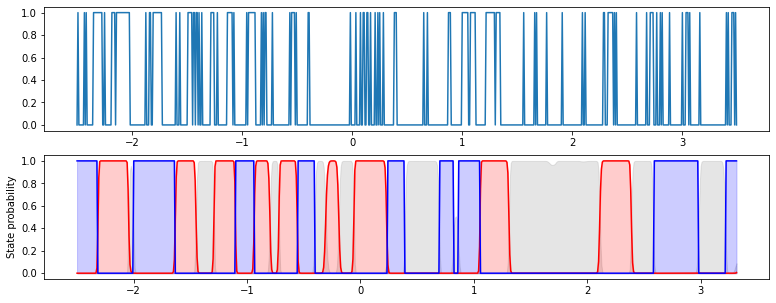

In [149]:
plt.figure(figsize=(13, 5))
plt.subplot(211)



threshold = np.percentile(np.abs(filtered),75)
plt.plot(te, np.abs(filtered)>threshold, label='signal')

plt.subplot(212)


# plot noise state
noise = np.argmax(np.mean(gamma, 0))
plt.fill_between(x=time, y1=gamma[:, noise], alpha=.2, color='gray')
p =gamma[:, 1]
p[p > 0.66] = 1
p[p < 0.66] = 0

states = np.where([i not in [noise] for i in range(3)])[0]
for i, col in zip(states, ['r', 'b']):
    plt.plot(time, gamma[:, i], col)
    plt.fill_between(x=time, y1=gamma[:, i], alpha=0.2, color=col)
    #plt.xlim(0, 10)
plt.ylabel('State probability')

d =gamma[:, 2]
d[d > 0.66] = 1
d[d < 0.66] = 0





# States spectral information

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 224, using nperseg = 224
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 219, using nperseg = 219
  .format(nperseg, input_length))


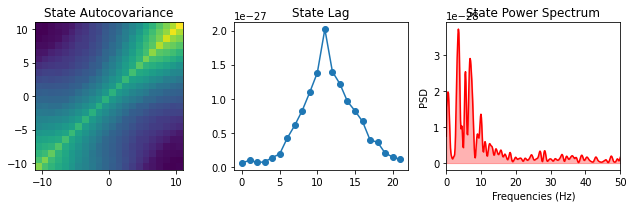

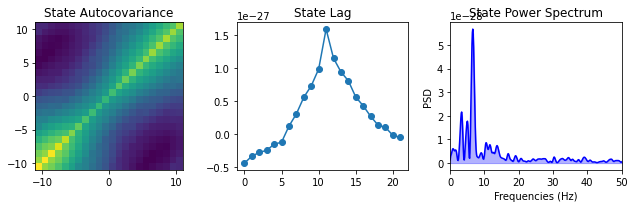

In [150]:
for i, col in zip(range(2), ['r', 'b']):

    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.title('State Autocovariance')
    plt.imshow(np.cov(xe[0, gamma[:, i]> .5, :].T), origin='lower', extent=[-11, 11, -11, 11])

    plt.subplot(132)
    plt.title('State Lag')
    x = np.cov(xe[0, gamma[:, i]> .5, :].T)[11, :]
    plt.plot(x, 'o-')
    
    plt.subplot(133)
    plt.title('State Power Spectrum')
    
    # Compute PSD separately for each lag
    tot = []
    for seg in xe[0, gamma[:, i]> .5].T:
        freqs, psd = signal.welch(x=seg, fs=120, nfft=1000)
        tot.append(psd)
    psd = np.mean(np.asarray(tot), 0)
    
    plt.plot(freqs, psd, col)
    plt.fill_between(x=freqs, y1=psd, color=col, alpha=0.3)
    plt.xlim(0, 50)
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.tight_layout()   
    plt.savefig('Spectral' + str(i) + '.png', dpi=600)

In [ ]:
s_post1 = []
bcount =0
bamplitude=0
bduration=0
bcount_1 =0
bamplitude_1=0
bduration_1=0




for i in range (len(T)):
  L= T[i]
  L= L[1380:1620]
  sos = signal.butter(4, [13, 30], 'bandpass', fs=120, output='sos')
  filtered = signal.sosfilt(sos, L)
  analytic_signal = signal.hilbert(filtered)
  amplitude_envelope = np.abs(analytic_signal)
  threshold = np.percentile(amplitude_envelope,75)

  remodel = hmm.GMMHMM(n_components=2,covariance_type="full", n_iter=100)
  remodel.fit(amplitude_envelope.reshape(-1, 1))
  proba = remodel.predict_proba(amplitude_envelope.reshape(-1, 1))
  q =proba[:, 0]
  q[q > 0.66] = 1
  q[q < 0.66] = 0

  w=proba[:, 1]
  w[w > 0.66] = 1
  w[w < 0.66] = 0

  z = amplitude_envelope>threshold
  if np.mean(w!=z) > np.mean(q!=z):
    b_state = q
  else:
    b_state = w
  grouped_L = []
  from itertools import groupby
  j=0
  grouped_L = [k for k,g in groupby(b_state)]
#h =[(k, (g+x for x-1 in g)) for k, g in groupby(grouped_L)]
  grouped_L1= []
  grouped_L3= []
  grouped_L4= []
  bamp_f=[]
  for k,g in groupby(b_state):
    j = j +sum(1 for i in g)
    grouped_L1.append (j)
#del grouped_L1[0]

  o=0
  bamp=0
  if grouped_L[0]==0:
    for i in range(0,len(grouped_L1)-1,2):
  
      o = o+ sum(b_state[grouped_L1[i]:grouped_L1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_L1[i]:grouped_L1[i+1]])

  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_L3.append(o)
        grouped_L4.append(bamp)
      o = 0
      bamp=0

  else:
    for i in range(1,len(grouped_L1),2):
  
      o = o+ sum(b_state[grouped_L1[i]:grouped_L1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_L1[i]:grouped_L1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_L3.append(o)
        grouped_L4.append(bamp)
      o=0
      bamp = 0
  bcount = bcount + len (grouped_L3)
  if len (grouped_L3) !=0:
    bamp_f = grouped_L4/sum(grouped_L3)
    bamplitude = bamplitude +np.mean(bamp_f)
    bduration = bduration + sum(grouped_L3)/len (grouped_L3)

  



  grouped_l = []
  j_1=0
  grouped_l = [k for k,g in groupby(z)]
#h =[(k, (g+x for x-1 in g)) for k, g in groupby(grouped_L)]
  grouped_l1= []
  grouped_l3= []
  grouped_l4= []
  bamp_f_1 = []
  for k,g in groupby(z):
    j_1 = j_1 +sum(1 for i in g)
    grouped_l1.append (j_1)
#del grouped_L1[0]

  o=0
  if grouped_l[0]==0:
    for i in range(0,len(grouped_l1)-1,2):
  
      o = o+ sum(z[grouped_l1[i]:grouped_l1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_l1[i]:grouped_l1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_l3.append(o)
        grouped_l4.append(bamp)
      o = 0

  else:
    for i in range(1,len(grouped_l1),2):
  
      o = o+ sum(z[grouped_l1[i]:grouped_l1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_l1[i]:grouped_l1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_l3.append(o)
        grouped_l4.append(bamp)
      o=0

  bcount_1 = bcount_1 + len (grouped_l3)
  if len (grouped_l3) !=0:
    bamp_f_1 = grouped_l4/sum(grouped_l3)
    bamplitude_1 = bamplitude_1 +np.mean(bamp_f_1)
    bduration_1 = bduration_1 + sum(grouped_l3)/len (grouped_l3)

s_post1.extend([bcount/(len(T)*2),bamplitude/len(T),bduration/len(T)*0.0833,bcount_1/(len(T)*2),bamplitude_1/len(T),bduration_1/len(T)*0.0833])
s_post1

In [ ]:
s1 = []
bcount =0
bamplitude=0
bduration=0
bcount_1 =0
bamplitude_1=0
bduration_1=0
#s= []

for i in range (len(T)):
  L= T[i]
  L= L[540:1260]
  sos = signal.butter(4, [13, 30], 'bandpass', fs=120, output='sos')
  filtered = signal.sosfilt(sos, L)
  analytic_signal = signal.hilbert(filtered)
  amplitude_envelope = np.abs(analytic_signal)
  threshold = np.percentile(amplitude_envelope,75)

  remodel = hmm.GMMHMM(n_components=2,covariance_type="full", n_iter=100)
  remodel.fit(amplitude_envelope.reshape(-1, 1))
  proba = remodel.predict_proba(amplitude_envelope.reshape(-1, 1))
  q =proba[:, 0]
  q[q > 0.66] = 1
  q[q < 0.66] = 0

  w=proba[:, 1]
  w[w > 0.66] = 1
  w[w < 0.66] = 0

  z = amplitude_envelope>threshold
  if np.mean(w!=z) > np.mean(q!=z):
    b_state = q
  else:
    b_state = w
  grouped_L = []
  from itertools import groupby
  j=0
  grouped_L = [k for k,g in groupby(b_state)]
#h =[(k, (g+x for x-1 in g)) for k, g in groupby(grouped_L)]
  grouped_L1= []
  grouped_L3= []
  grouped_L4= []
  bamp_f=[]
  for k,g in groupby(b_state):
    j = j +sum(1 for i in g)
    grouped_L1.append (j)
#del grouped_L1[0]

  o=0
  bamp=0
  if grouped_L[0]==0:
    for i in range(0,len(grouped_L1)-1,2):
  
      o = o+ sum(b_state[grouped_L1[i]:grouped_L1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_L1[i]:grouped_L1[i+1]])

  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_L3.append(o)
        grouped_L4.append(bamp)
      o = 0
      bamp=0

  else:
    for i in range(1,len(grouped_L1),2):
  
      o = o+ sum(b_state[grouped_L1[i]:grouped_L1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_L1[i]:grouped_L1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_L3.append(o)
        grouped_L4.append(bamp)
      o=0
      bamp = 0
  bcount = bcount + len (grouped_L3)
  bamp_f = grouped_L4/sum(grouped_L3)
  bamplitude = bamplitude +np.mean(bamp_f)
  bduration = bduration + sum(grouped_L3)/len (grouped_L3)

  



  grouped_l = []
  j_1=0
  grouped_l = [k for k,g in groupby(z)]
#h =[(k, (g+x for x-1 in g)) for k, g in groupby(grouped_L)]
  grouped_l1= []
  grouped_l3= []
  grouped_l4= []
  bamp_f_1 = []
  for k,g in groupby(z):
    j_1 = j_1 +sum(1 for i in g)
    grouped_l1.append (j_1)
#del grouped_L1[0]

  o=0
  if grouped_l[0]==0:
    for i in range(0,len(grouped_l1)-1,2):
  
      o = o+ sum(z[grouped_l1[i]:grouped_l1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_l1[i]:grouped_l1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_l3.append(o)
        grouped_l4.append(bamp)
      o = 0

  else:
    for i in range(1,len(grouped_l1),2):
  
      o = o+ sum(z[grouped_l1[i]:grouped_l1[i+1]])
      bamp = bamp+ sum(amplitude_envelope[grouped_l1[i]:grouped_l1[i+1]])
  #o = o+ sum(q[(i-1):grouped_L1[i]])
      if o > 12:
        grouped_l3.append(o)
        grouped_l4.append(bamp)
      o=0

  bcount_1 = bcount_1 + len (grouped_l3)
  if len (grouped_l3) !=0:
    
    bamp_f_1.extend([ grouped_l4/sum(grouped_l3)])
    bamplitude_1 = bamplitude_1 +np.mean(bamp_f_1)
    bduration_1 = bduration_1 + sum(grouped_l3)/len (grouped_l3)

s1.extend([bcount/(len(T)*6),bamplitude/len(T),bduration/len(T)*0.00833,bcount_1/(len(T)*6),bamplitude_1/len(T),bduration_1/len(T)*0.00833])

s1

# References

[1] Vidaurre, D., Hunt, L. T., Quinn, A. J., Hunt, B. A. E., Brookes, M. J., Nobre, A. C., & Woolrich, M. W. (2018). Spontaneous cortical activity transiently organises into frequency specific phase-coupling networks. Nature Communications, 9(1). https://doi.org/10.1038/s41467-018-05316-z

[2] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G., Nowak, M., Seedat, Z. A., … Woolrich, M. W. (2019). Unpacking Transient Event Dynamics in Electrophysiological Power Spectra. Brain Topography, 32(6), 1020–1034. https://doi.org/10.1007/s10548-019-00745-5